In [35]:
!pip install pmdarima
!pip install statsmodels
%matplotlib inline

In [4]:
import pandas as pd
from pmdarima import arima
from pmdarima import utils
import matplotlib.pyplot as plt

read time series dataset and plot

In [12]:
grp_canceled = pd.read_csv('./canceledByWeek.csv')
grp_canceled.loc[:,'YearWeek'] = grp_canceled.loc[:,'YearWeek'].map(str)

In [13]:
grp_canceled.head(5)

,YearWeek,IsCanceled
0,201527,41
1,201528,48
2,201529,87
3,201530,74
4,201531,101


plot time series 

In [27]:
def plotSeries(data,column):
    fig, ax = plt.subplots(figsize=(15,10))

    ax.plot(grp_canceled.YearWeek, grp_canceled[column], color='tab:orange',label="Cancelled Trips")

    ax.set_xlabel('Year and Week')
    plt.xticks(rotation=90)
    ax.set_ylabel('# Canceled trips')
    ax.set_title('Time Series of Canceled trips by week')
    ax.legend(loc='upper left');

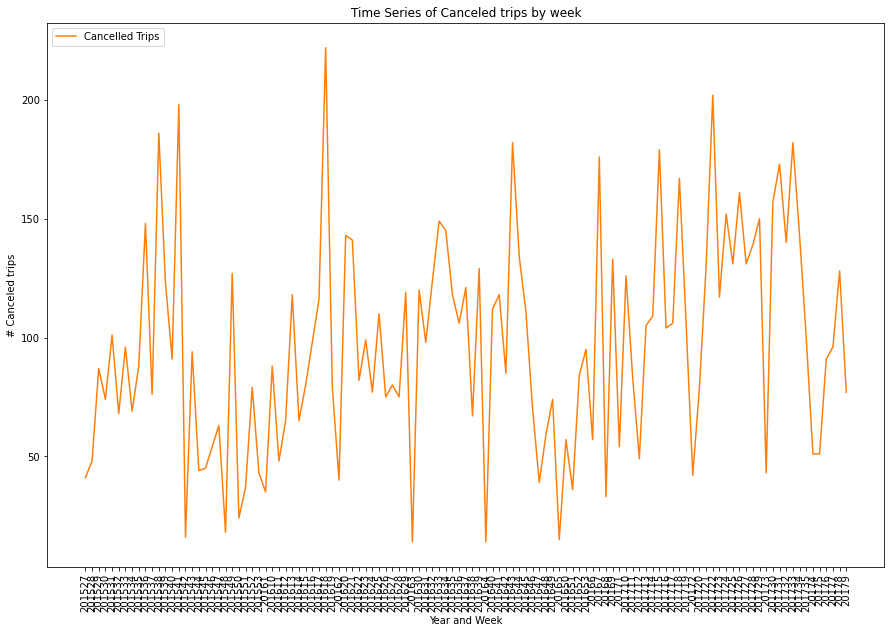

In [28]:
plotSeries(grp_canceled,['IsCanceled'])

decompose the series using additive decomposition becasue the trend is relative stable and using 52 as frecuency (we divide the data in weeks)


Text(0.5, 1.0, 'Canceled Seasonal Decomposition')

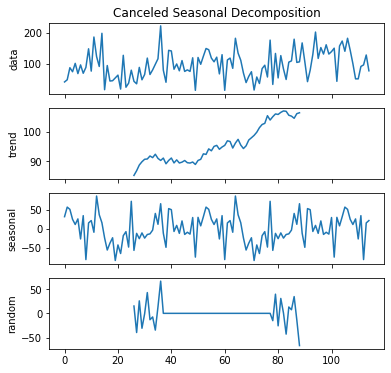

In [18]:
decomposed = arima.decompose(grp_canceled['IsCanceled'], 'additive', m=52)

figure_kwargs = {'figsize': (6, 6)}
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,show=False)
axes[0].set_title("Canceled Seasonal Decomposition")

the trend component shows us we have a not stationary time series based on that we are going to apply some transformation like 1 difference until we get a stationary time series


In [32]:
grp_canceled.loc[:,'diff1'] = grp_canceled.loc[:,'IsCanceled'] - grp_canceled.loc[:,'IsCanceled'].shift(1)

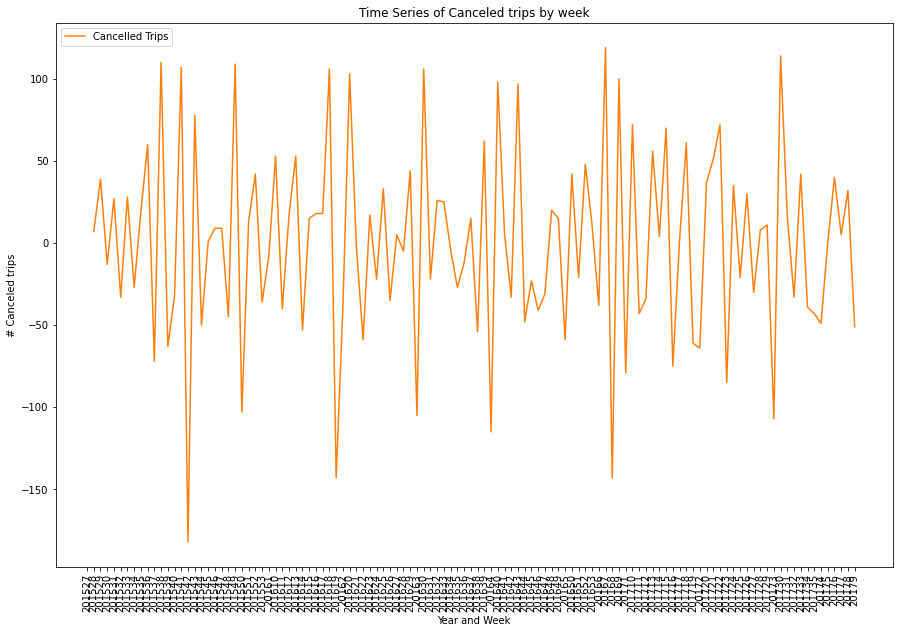

In [34]:
plotSeries(grp_canceled,['diff1'])

we are going to test stationary using Augmented Dickey-Fuller test

In [38]:
from statsmodels.tsa.stattools import adfuller

X = grp_canceled.diff1[1:len(grp_canceled)]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.131872
p-value: 0.000000


In our case we get a p-value less than 0.05 so we reject the null hypothesis (H0), meaning the data does not have a unit root and is stationary.

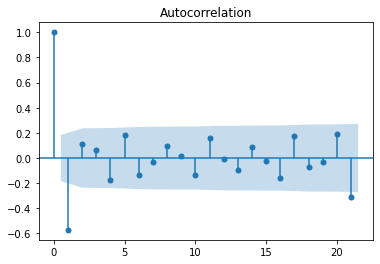

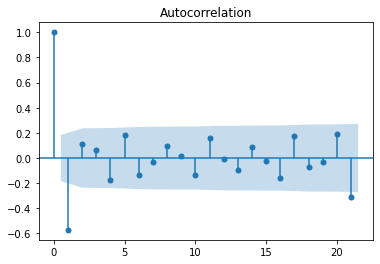

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(grp_canceled.diff1[1:len(grp_canceled)])

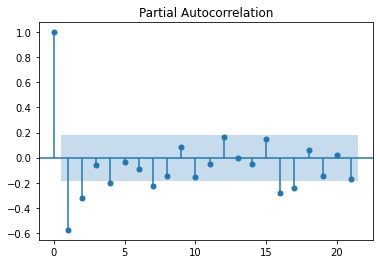

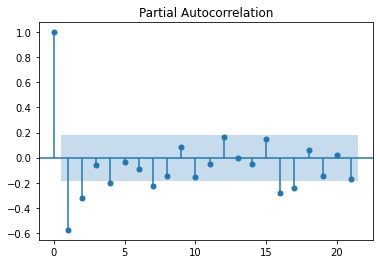

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(grp_canceled.diff1[1:len(grp_canceled)])

based on acf and pacf we propose ARMA(2,1,1), ARMA(3,1,1)

Calculate  4-week moving average on the time series

In [52]:
rolling = grp_canceled['diff1'].rolling(4, min_periods=4).mean()

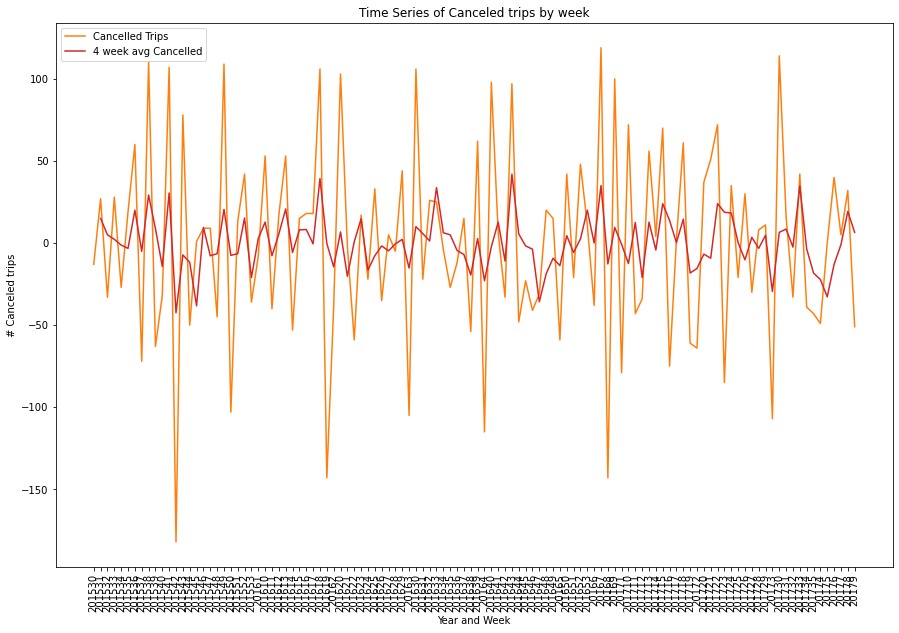

In [53]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(grp_canceled.YearWeek[3:len(rolling)], grp_canceled.loc[3:len(rolling),'diff1'], color='tab:orange',label="Cancelled Trips")
ax.plot(grp_canceled.YearWeek[3:len(rolling)], rolling[3:len(rolling)], color='tab:red',label="4 week avg Cancelled")

ax.set_xlabel('Year and Week')
plt.xticks(rotation=90)
ax.set_ylabel('# Canceled trips')
ax.set_title('Time Series of Canceled trips by week')
ax.legend(loc='upper left');

create train and test set 

In [62]:
train_limit = round(len(grp_canceled)*0.9)

train_df = grp_canceled.loc[1:train_limit,['YearWeek','diff1']]
test_df = grp_canceled.loc[train_limit+1:len(grp_canceled),['YearWeek','diff1']]

In [66]:
train_df.to_csv('./train.csv')

In [65]:
test_df.to_csv('./test.csv')